<a href="https://colab.research.google.com/github/GustavoGran/ecommerce_recomender/blob/main/ptc_3467_brazillian_ecommerce_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análise Exploratória de Dados - Dados de E-commerce Brasileiro**


##**Importando Bibliotecas**

In [ ]:
import pandas as pd
import numpy  as np
from scipy import stats 
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install geopandas
import geopandas as gpd

##**Autenticando conexão com o Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# %cd "/content/drive/My Drive/Colab Notebooks/datasets/olist_ecommerce"
%cd "/content/drive/Shared drives/Projeto Ciência de Dados/dataset/olist_ecommerce" 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shared drives/Projeto Ciência de Dados/dataset/olist_ecommerce


In [ ]:
%ls

olist_customers_dataset.csv       olist_orders_dataset.csv
olist_geolocation_dataset.csv     olist_products_dataset.csv
olist_order_items_dataset.csv     olist_sellers_dataset.csv
olist_order_payments_dataset.csv  product_category_name_translation.csv
olist_order_reviews_dataset.csv


##**Leitura dos datasets**

Os dados do e-commerce disponibilizados estão espalhados em uma série de tabelas diferentes que podem ser integradas a partir de algumas chaves (id's). As seguintes informações podem ser extraídas dos diversos datasets.

*   Informações de localização dos clientes
*   Informações de localização dos vendedores
*   Histórico de compras dos clientes





In [ ]:
customers_file_name = 'olist_customers_dataset.csv'
orders_file_name = 'olist_orders_dataset.csv'
geolocation_file_name = 'olist_geolocation_dataset.csv'
products_file_name = 'olist_products_dataset.csv'
items_file_name = 'olist_order_items_dataset.csv'
sellers_file_name = 'olist_sellers_dataset.csv'
order_pay_file_name = 'olist_order_payments_dataset.csv'
category_file_name = 'product_category_name_translation.csv'
reviews_file_name = 'olist_order_reviews_dataset.csv'

In [ ]:
df_customers = pd.read_csv(customers_file_name)
df_orders = pd.read_csv(orders_file_name)
df_geolocation = pd.read_csv(geolocation_file_name)
df_products = pd.read_csv(products_file_name)
df_items = pd.read_csv(items_file_name)
df_sellers = pd.read_csv(sellers_file_name)
df_order_pay = pd.read_csv(order_pay_file_name)
df_category = pd.read_csv(category_file_name)
df_reviews = pd.read_csv(reviews_file_name)

## **Tendo uma pequena noção do que há em cada dataset** 

In [ ]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

def plot_count_plot(df, col, total, title, label):
  f, ax = plt.subplots(figsize=(12,6))
  g = sns.countplot(data=df, x=col)

  g.set_title(title, fontsize = 22);
  g.set_xlabel(label,fontsize = 16);
  g.set_ylabel('');
  ax.grid(False)
  sns.despine(offset=10, trim=True, left=True, bottom=True);

  sizes = []

  for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(x= p.get_x()+p.get_width()/2.,
          y= height +0.01*total,
          s='{:1.2f}%'.format(height/total*100),
          ha="center", fontsize=14,)
    
  g.set_ylim(0, max(sizes) * 1.1)

  plt.show()

### **Dataset de Clientes**

* Nota-se que não há grande riqueza de informações demográficas dos clientes
* Um algoritmo de clusterização desses clientes não poderia se basear unicamente em caracterísicas demográficas
* O prefizo do zip_code (CEP) pode ser utlizado para cruzamento com o dataset de geolocalização para medições de distância entre os clientes e vendedores em um trabalho de enriquecimento
* Todos os campos de dimensões são categóricos


In [ ]:
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


* Há duas chaves de clientes, uma que identifica o cliente durante uma compra (customer_id) e outro que identifica o cliente de forma única (customer_unique_id).
* Isso se torna interessante pois mantém a informação histórica de localização do cliente durante cada compra e não uma foto atual de sua localização atual.
* Podemos notar que possuímos informações de aproximadamente 100k compras nos últimos 2 anos

In [ ]:
df_customers.shape

(99441, 5)

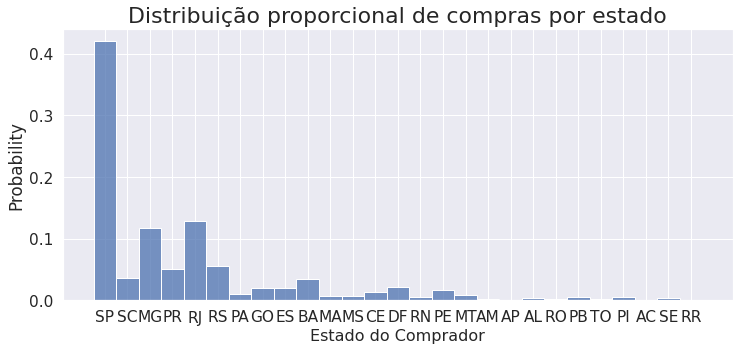

In [ ]:
plt.figure(figsize=(12,5));
sns.set_color_codes("dark")
g1 = sns.histplot(df_customers['customer_state'],stat='probability');
g1.set_title('Distribuição proporcional de compras por estado', fontsize = 22);
g1.set_xlabel('Estado do Comprador',fontsize = 16);

In [ ]:
round(100*(df_customers.customer_city.value_counts()/df_customers.shape[0]),2)

sao paulo              15.63
rio de janeiro          6.92
belo horizonte          2.79
brasilia                2.14
curitiba                1.53
                       ...  
ewbank da camara        0.00
bodo                    0.00
ouro verde do oeste     0.00
pareci novo             0.00
mucuge                  0.00
Name: customer_city, Length: 4119, dtype: float64

* Podemos notar pela distribuição de compras por estado (histograma) que quase metade das compras (42%) estão concentradas no estado de São Paulo, das quais aproximadamente 1/3 ocorrem na cidade de São Paulo.

* A distribuição de compras por cidade mostra-se pulverizado, dado que apenas 2 capitais possuem acima de 3% de participação nas compras totais



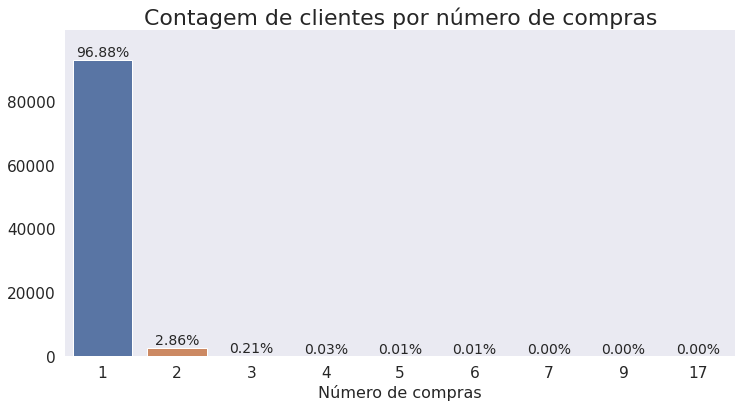

In [ ]:
df_unique_customers = df_customers.groupby('customer_unique_id', as_index=False).agg({'customer_id':'count'})

plot_count_plot(df_unique_customers,'customer_id',
                df_unique_customers.customer_unique_id.count(), 
                'Contagem de clientes por número de compras',
                'Número de compras')

* Dado que boa parte dos clientes são únicos torna-se difícil utilizar algum modelo baseado em histórico de vendas.

* Uma outra abordagem seria agrupar os clientes com características demográficas similares para utilizar o histórico de vendas do grupo como um preditor do review score ou dos produtos mais interessantes, porém a única informação classificatória entre clientes é sua localização, o que torna ainda mais difícil uma abordagem voltada a histórico.

* Os dados até aqui sugerem a utilização de um modelo de recomendação **cold start** baseado na localização dos clientes e, eventualmente, em produtos mais vendidos como um todo.

### **Dataset de Compras**

* Oferece informações ricas com relação ao processo de compra e entrega do produto.
* Pode ser utilizado para avaliação de métricas de OTIF (On time In Full) onde procura-se avaliar se os produtos foram entregues no prazo 
* A chave order_id parece essencial para relacionar essa métricas com demais bases e representa uma chave única para identificação de uma compra



In [ ]:
resumetable(df_orders)

Dataset Shape: (99441, 8)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,order_id,object,0,99441,e481f51cbdc54678b7cc49136f2d6af7,53cdb2fc8bc7dce0b6741e2150273451,47770eb9100c2d0c44946d9cf07ec65d,16.60
1,customer_id,object,0,99441,9ef432eb6251297304e76186b10a928d,b0830fb4747a6c6d20dea0b8c802d7ef,41ce2a54c0b03bf3443c3d931a367089,16.60
2,order_status,object,0,8,delivered,delivered,delivered,0.26
3,order_purchase_timestamp,object,0,98875,2017-10-02 10:56:33,2018-07-24 20:41:37,2018-08-08 08:38:49,16.59
4,order_approved_at,object,160,90733,2017-10-02 11:07:15,2018-07-26 03:24:27,2018-08-08 08:55:23,16.41
5,order_delivered_carrier_date,object,1783,81018,2017-10-04 19:55:00,2018-07-26 14:31:00,2018-08-08 13:50:00,16.15
6,order_delivered_customer_date,object,2965,95664,2017-10-10 21:25:13,2018-08-07 15:27:45,2018-08-17 18:06:29,16.54
7,order_estimated_delivery_date,object,0,459,2017-10-18 00:00:00,2018-08-13 00:00:00,2018-09-04 00:00:00,8.47


* Como era esperado, o número de linhas (compras) é igual ao número de compras do dataset de clientes, o que sugere uma integração do tipo 1:1 pela chave **customer_id** 

####**Status de entrega**
* Os dados categóricos de status de entrega parecem não agregar significativamente para a análise, dado que quase a totalidade dos pedidos aparece com o status de entregue.
* Aparentemente não há informações de produtos devolvidos neste dataset
* Parece ser interessante filtrar os dados com status de entrega diferente de "delivered"

In [ ]:
df_orders['order_status'].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [ ]:
round(100*(df_orders['order_status'].value_counts()/df_orders.shape[0]),2)

delivered      97.02
shipped         1.11
canceled        0.63
unavailable     0.61
invoiced        0.32
processing      0.30
created         0.01
approved        0.00
Name: order_status, dtype: float64

In [ ]:
# drop non-relevant orders
df_orders.drop(df_orders[df_orders['order_status'] != 'delivered'].index, inplace=True);

order_date_cols = ['order_purchase_timestamp',
                   'order_delivered_customer_date',
                   'order_estimated_delivery_date']

# Drop nan values
df_orders.dropna(inplace=True)

df_orders[order_date_cols] = df_orders[order_date_cols].apply(pd.to_datetime)

df_orders['delivery_days'] = ((df_orders['order_delivered_customer_date'].dt.date 
                              - df_orders['order_purchase_timestamp'].dt.date)/np.timedelta64(1,'D')).astype(int)

df_orders['late_delivery_days'] = ((df_orders['order_delivered_customer_date'].dt.date 
                                    - df_orders['order_estimated_delivery_date'].dt.date)
                                    /np.timedelta64(1,'D')).astype(int)

df_orders['estimated_delivery_days'] = ((df_orders['order_estimated_delivery_date'].dt.date 
                                    - df_orders['order_purchase_timestamp'].dt.date)
                                    /np.timedelta64(1,'D')).astype(int)

df_orders['is_late'] = df_orders['late_delivery_days'] > 0

order_cols_keep = ['order_id','customer_id','delivery_days','late_delivery_days','estimated_delivery_days','is_late']

df_orders = df_orders[order_cols_keep]           
df_orders.head()

,order_id,customer_id,delivery_days,late_delivery_days,estimated_delivery_days,is_late
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,8,-8,16,False
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,14,-6,20,False
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,9,-18,27,False
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,14,-13,27,False
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,3,-10,13,False


####**Dias de entrega da compra**
* As datas de compra, entrega e previsão de entrega são informações interessantes, mas é necessário transformá-las em métricas mais interessante para comparação entre compras.

* Para isso serão adicionadas 2 colunas:
  * Número de dias de entrega 
  * Número de dias de atraso de entrega (Negativo se entregue de forma adiantada)

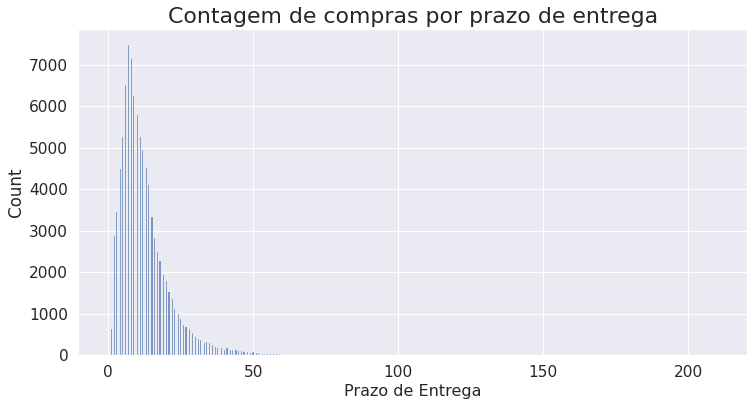

In [ ]:
plt.figure(figsize=(12,6));
g2 = sns.histplot(df_orders['delivery_days'])
g2.set_title('Contagem de compras por prazo de entrega', fontsize = 22);
g2.set_xlabel('Prazo de Entrega',fontsize = 16);

* Podemos verificar que o número de dias de entrega parece seguir uma distribuição **lognormal**. Podemos aplicar uma função ln(x+1) para obtermos uma distribuição mais próxima de uma normal, que poderá responder melhor a a algoritmos de regressão / classficiação 

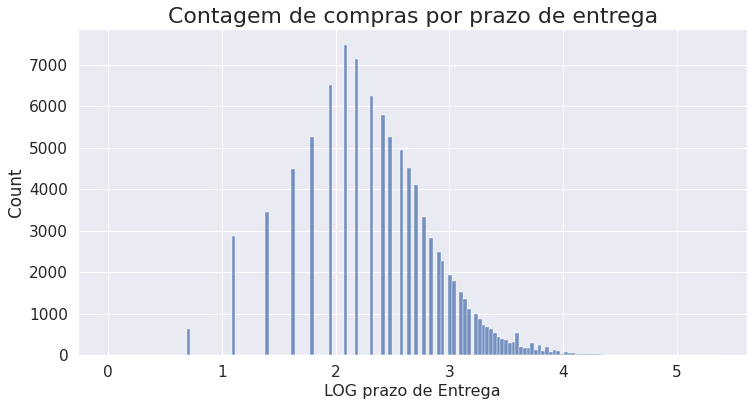

In [ ]:
plt.figure(figsize=(12,6));
# somar 1 somente para evitar erro no log para 0 days
g3 = sns.histplot(np.log(df_orders['delivery_days']+1)) 
g3.set_title('Contagem de compras por prazo de entrega', fontsize = 22);
g3.set_xlabel('LOG prazo de Entrega',fontsize = 16);

* A distribuição de dias de atraso de entrega parece seguir uma distribuição normal, apesar da presença aparente de outliers

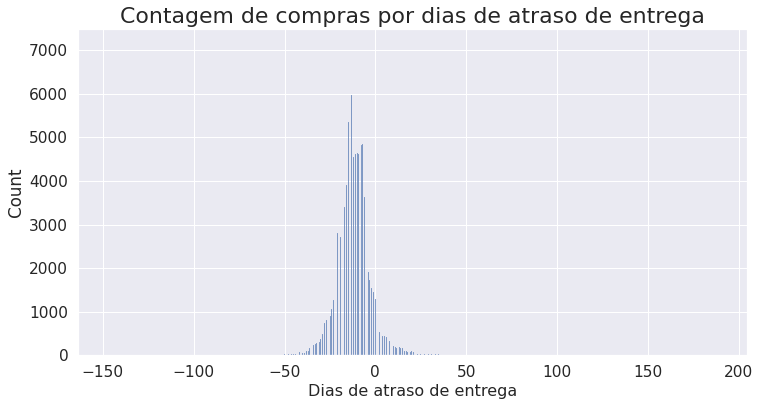

In [ ]:
plt.figure(figsize=(12,6));
g4 = sns.histplot(df_orders['late_delivery_days'])
g4.set_title('Contagem de compras por dias de atraso de entrega', fontsize = 22);
g4.set_xlabel('Dias de atraso de entrega',fontsize = 16);

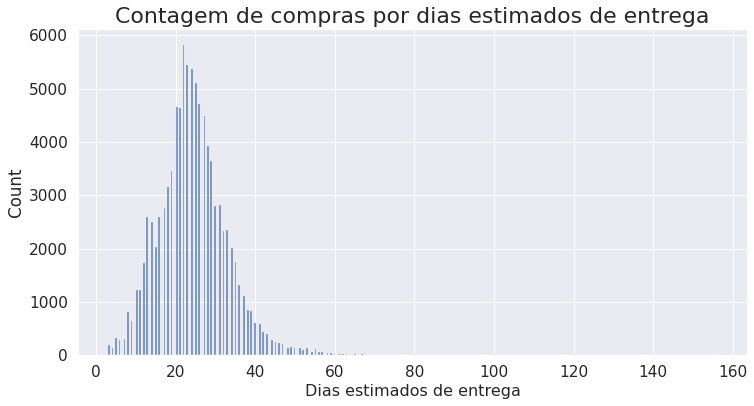

In [ ]:
plt.figure(figsize=(12,6));
g4 = sns.histplot(df_orders['estimated_delivery_days'])
g4.set_title('Contagem de compras por dias estimados de entrega', fontsize = 22);
g4.set_xlabel('Dias estimados de entrega',fontsize = 16);

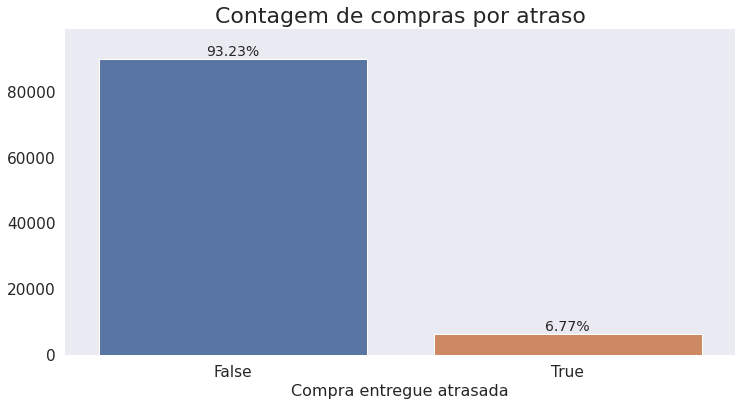

In [ ]:
plot_count_plot(df_orders,'is_late',
                df_orders.order_id.nunique(), 
                'Contagem de compras por atraso',
                'Compra entregue atrasada')

###**Dataset de Produtos**

* Além de descrições gerais da compra como prazo de entrega, clientes e vendedores envolvidos, os datasets de itens e produtos tentam trazer uma visão de quais itens compõem a cesta de compras
* Olhando um pequeno trecho de cada um é possível notar que não  há informações classificatórias quanto ao tipo de produto, o que dificultaria sua classficiação em macro-categorias.
* Por outro lado, há descrições das dimensões físicas e peso do produto, que podem estar diretamente correlacionadas com o custo de frete, prazo de entrega e preço
* Notam-se também informações referentes ao anúncio do produto, como tamanho do nome, tamanho da descrição  e quantidade de fotos.Essas variáveis podem estar relacionadas ao fato dos produtos serem mais ou menos vendidos, afinal, é de se esperar que um produto com mais informações dê mais segurança ao cliente, portanto aumentando a probabilidade de compra.
* Esse dataset pode ser um insumo importante para algoritmos de classificação



In [ ]:
resumetable(df_products)

Dataset Shape: (32951, 9)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,product_id,object,0,32951,1e9e8ef04dbcff4541ed26657ea517e5,3aa071139cb16b67ca9e5dea641aaa2f,96bd76ec8810374ed1b65e291975717f,15.01
1,product_category_name,object,610,73,perfumaria,artes,esporte_lazer,4.80
2,product_name_lenght,float64,610,66,40,44,46,5.09
3,product_description_lenght,float64,610,2960,287,276,250,10.72
4,product_photos_qty,float64,610,19,1,1,1,2.16
5,product_weight_g,float64,2,2204,225,1000,154,7.56
6,product_length_cm,float64,2,99,16,30,18,5.06
7,product_height_cm,float64,2,102,10,18,9,5.15
8,product_width_cm,float64,2,95,14,20,15,4.85


* Nota-se que há uma quantidade não muito grande de categorias de produtos (abaixo de 100)

* Uma análise interessante seria avaliar a quantidade de produtos disponíveis por categoria

* Podemos investigar futuramente quais dessas categorias são mais ou menos compradas

In [ ]:
print('Number of products: ',df_products.product_id.count())
print('Unique products: ',df_products.product_id.nunique())
print('Unique product categories: ',df_products.product_category_name.nunique())

Number of products:  32951
Unique products:  32951
Unique product categories:  73


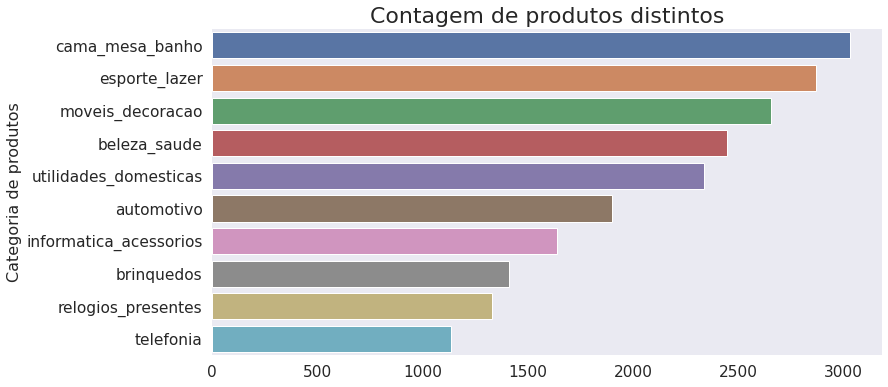

In [ ]:
f, ax = plt.subplots(figsize=(12,6))
g5 = sns.barplot(x= 'product_id',y = 'product_category_name', 
  data=(df_products
    .groupby('product_category_name',as_index=False)
    .product_id
    .nunique()
    .sort_values(by='product_id',ascending=False)).head(10),
)
g5.set_title('Contagem de produtos distintos', fontsize = 22);
g5.set_xlabel('');
g5.set_ylabel('Categoria de produtos',fontsize = 16);
ax.grid(False)
sns.despine(offset=10, trim=True, left=True, bottom=True);
plt.show()

* Como era de se esperar, o peso do produto possue uma correlação média com as variáveis que indicam suas dimensões, ficando em torno de 0.5

* As descrições do anúncio, no entanto, parecem ter uma correlação extremamente baixa

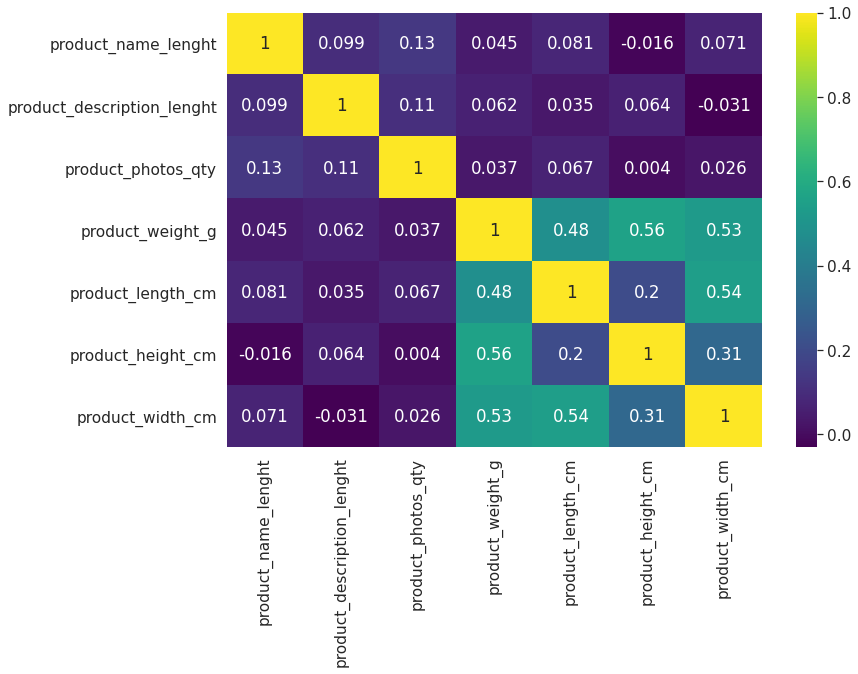

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(df_products.corr(),cmap = 'viridis',annot=True) 

### **Dataset de Itens**
* O dataset de itens funciona como uma tabela fato, relacionando as dimensões de compras (order_id) às dimensões de produtos (product_id) e dimensões de vendedores (seller_id)
* Há também métricas de preços e de fretes para cada produto dentro de uma compra, bem como uma data que parece ser a data limite de entrega

In [ ]:
resumetable(df_items)

Dataset Shape: (112650, 7)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,order_id,object,0,98666,00010242fe8c5a6d1ba2dd792cb16214,00018f77f2f0320c557190d7a144bdd3,000229ec398224ef6ca0657da4fc703e,16.49
1,order_item_id,int64,0,21,1,1,1,0.72
2,product_id,object,0,32951,4244733e06e7ecb4970a6e2683c13e61,e5f2d52b802189ee658865ca93d83a8f,c777355d18b72b67abbeef9df44fd0fd,13.63
3,seller_id,object,0,3095,48436dade18ac8b2bce089ec2a041202,dd7ddc04e1b6c2c614352b383efe2d36,5b51032eddd242adc84c38acab88f23d,9.48
4,shipping_limit_date,object,0,93318,2017-09-19 09:45:35,2017-05-03 11:05:13,2018-01-18 14:48:30,16.38
5,price,float64,0,5968,58.9,239.9,199,9.58
6,freight_value,float64,0,6999,13.29,19.93,17.87,10.51


* Uma primeira análise relevante a ser feita é investigar a distribuição estatística de preços de produtos e fretes

* Podemos observar que ambas parecem apresentar um comportamento de distribuição lognormal.O logaritmo dessas variáveis provavelmente apresentará comportamento próximo a uma distribuição normal
* Artigo massa: [Interpretação de transformação log e motivos](https://medium.com/@kyawsawhtoon/log-transformation-purpose-and-interpretation-9444b4b049c9)

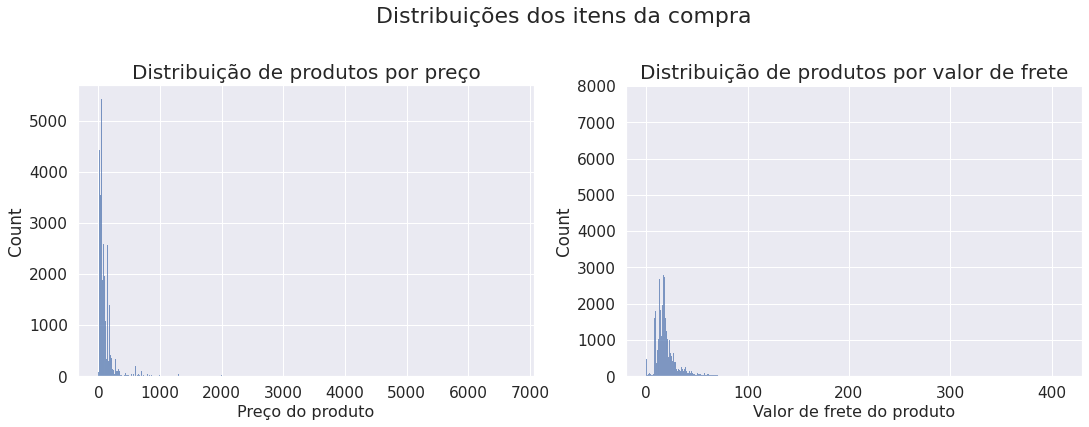

In [ ]:
plt.figure(figsize=(18,6));
plt.suptitle('Distribuições dos itens da compra', fontsize=22)

plt.subplot(121)
g7 = sns.histplot(df_items['price'])
g7.set_title('Distribuição de produtos por preço', fontsize = 20);
g7.set_xlabel('Preço do produto',fontsize = 16);

plt.subplot(122)
g7 = sns.histplot(df_items['freight_value'])
g7.set_title('Distribuição de produtos por valor de frete', fontsize = 20);
g7.set_xlabel('Valor de frete do produto',fontsize = 16);

plt.subplots_adjust(hspace = 0.5, top = 0.8)

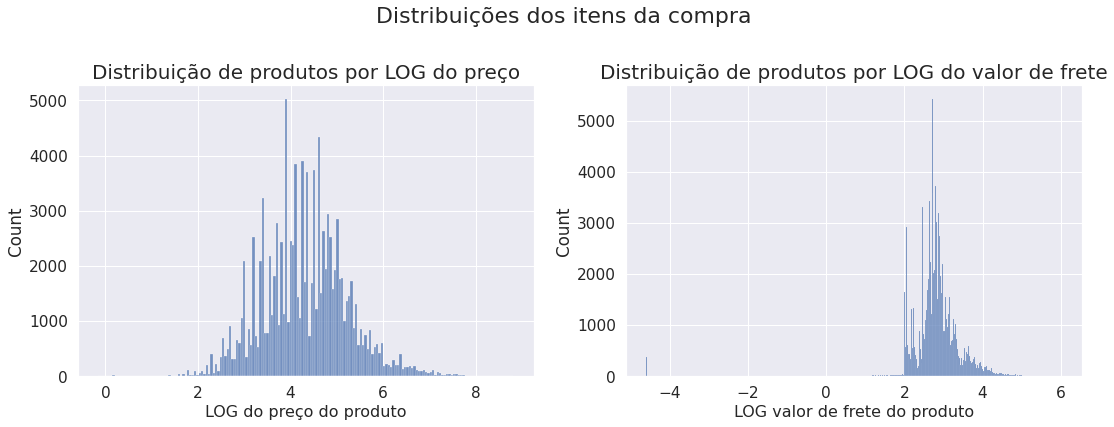

In [ ]:
df_items['price_log'] = np.log(df_items['price']+0.01);
df_items['freight_value_log'] = np.log(df_items['freight_value']+0.01);

plt.figure(figsize=(18,6));
plt.suptitle('Distribuições dos itens da compra', fontsize=22)

plt.subplot(121)
g8 = sns.histplot(df_items['price_log'])
g8.set_title('Distribuição de produtos por LOG do preço', fontsize = 20);
g8.set_xlabel('LOG do preço do produto',fontsize = 16);

plt.subplot(122)
g9 = sns.histplot(df_items['freight_value_log'])
g9.set_title('Distribuição de produtos por LOG do valor de frete', fontsize = 20);
g9.set_xlabel('LOG valor de frete do produto',fontsize = 16);

plt.subplots_adjust(hspace = 0.5, top = 0.8)

* Com a distribuição logaritmica do preço e do valor de frete, torna-se muito mais simples a identificação de outliers

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn

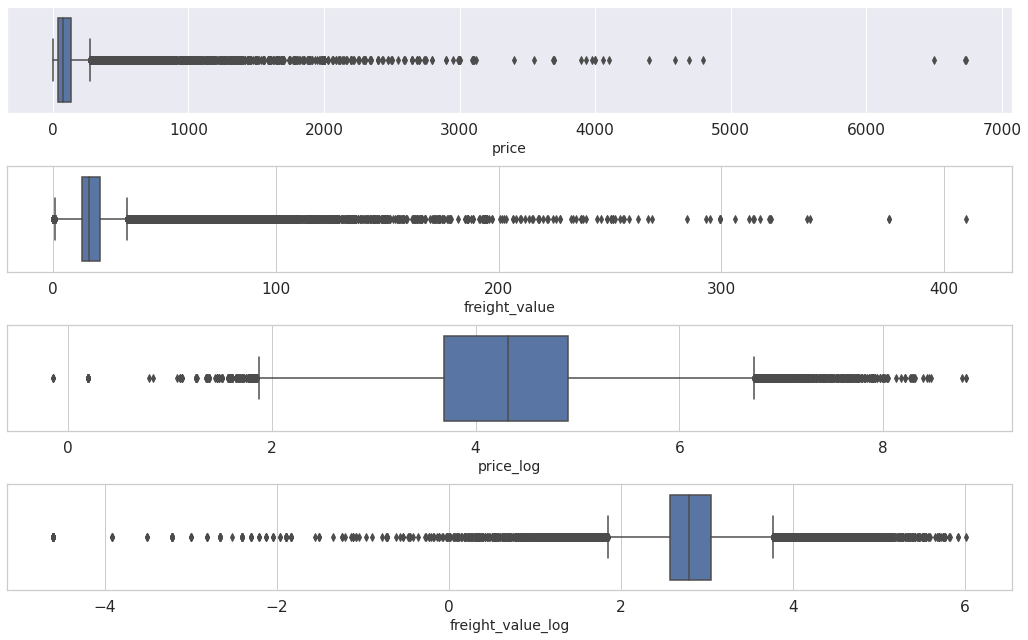

In [ ]:
plt.figure(figsize= (18,12))
itemcols = ['price','freight_value','price_log','freight_value_log']
for i in range(0, len(itemcols)):
  plt.subplot(len(itemcols),1,i+1)
  sns.set_style('whitegrid')
  g = sns.boxplot(df_items[itemcols[i]])
  g.set_xlabel(itemcols[i],fontsize=14)

plt.subplots_adjust(hspace = 0.5, top = 0.8)

###**Dataset de Geolocalização**

* Traz um mapeamento de zip-codes para latitude e longitude, bem como a cidade e o estado aos quais essas informações são relativas

* Permite o cálculo de métricas de distância entre vendedor e comprador

* Permite visualização gráfica


In [ ]:
resumetable(df_geolocation)

Dataset Shape: (1000163, 5)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,geolocation_zip_code_prefix,int64,0,19015,1037,1046,1046,13.32
1,geolocation_lat,float64,0,717358,-23.5456,-23.5461,-23.5461,19.11
2,geolocation_lng,float64,0,717613,-46.6393,-46.6448,-46.643,19.11
3,geolocation_city,object,0,8011,sao paulo,sao paulo,sao paulo,8.73
4,geolocation_state,object,0,27,SP,SP,SP,3.13


* Uma das primeiras coisas que podemos notar é que há um número muito grande de zip_codes com diferentes latitudes e longitudes. Isso ocorre porque o dado disponível corresponde a um prefixo de zip_code, ao qual muitos sufixos podem esta associados
* A solução mais interessante nos parece ser agrupar por prefixo de zip_code calculando a média de latitude e longitude 

In [ ]:
df_geolocation.drop(columns=['geolocation_city','geolocation_state'],inplace=True)

df_geolocation = df_geolocation.groupby('geolocation_zip_code_prefix', as_index=False).agg('mean')
resumetable(df_geolocation)

Dataset Shape: (19015, 3)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,geolocation_zip_code_prefix,int64,0,19015,1001.000000,1002.000000,1003.000000,14.21
1,geolocation_lat,float64,0,19005,-23.550190,-23.548146,-23.548994,14.21
2,geolocation_lng,float64,0,19004,-46.634024,-46.634979,-46.635731,14.21


* Agora podemos realizar a integração desse dadataset com os datasets de clientes e datasets de vendedores 

In [ ]:
from shapely.geometry import Point

In [ ]:
df_customers = df_customers.merge(
    df_geolocation.rename(columns={'geolocation_zip_code_prefix':'customer_zip_code_prefix',
                                  'geolocation_lat':'customer_lat',
                                  'geolocation_lng':'customer_lng'}),
                          how='left',
                          on='customer_zip_code_prefix')

df_customers.drop(columns=['customer_zip_code_prefix'],inplace=True)

customers_geometry = [Point(xy) for xy in zip(df_customers['customer_lng'],df_customers['customer_lat'])]

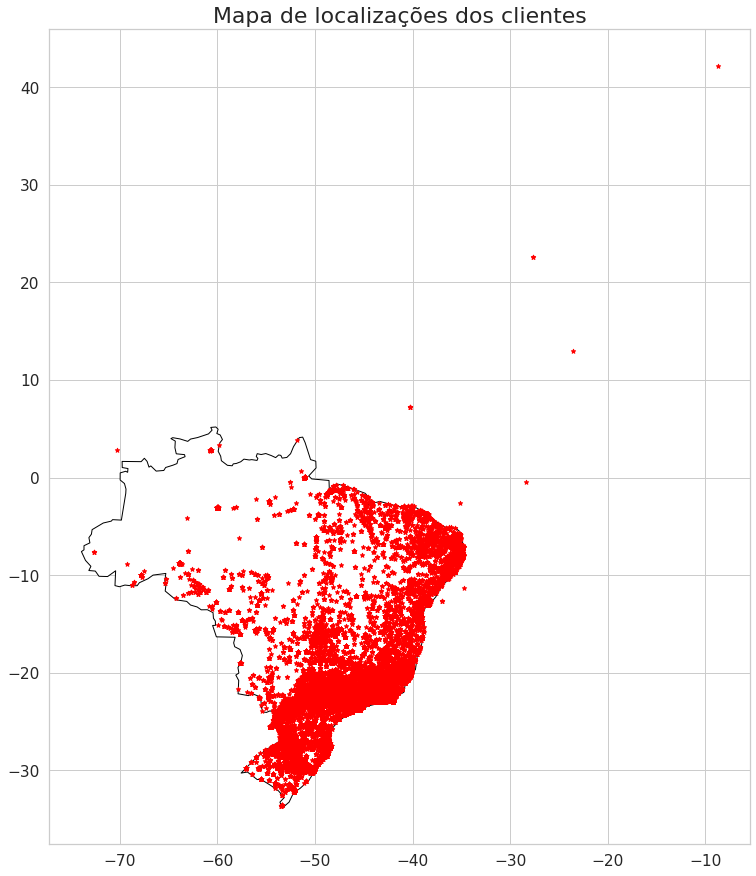

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filtrar Brasil
fig,ax = plt.subplots(figsize = (15,15))
brazil_map_ax = world[world.name == 'Brazil'].plot(color='white', edgecolor='black', ax=ax);

g = gpd.GeoDataFrame(geometry = customers_geometry).plot(ax = brazil_map_ax, markersize = 20, 
          color = 'red', marker = '*',label = 'Brazil')

g.set_title('Mapa de localizações dos clientes', fontsize=22)
plt.show()

In [ ]:
df_sellers = df_sellers.merge(
    df_geolocation.rename(columns={'geolocation_zip_code_prefix':'seller_zip_code_prefix',
                                  'geolocation_lat':'seller_lat',
                                  'geolocation_lng':'seller_lng'}),
                          how='left',
                          on='seller_zip_code_prefix')
df_sellers.drop(columns=['seller_zip_code_prefix'],inplace=True)

sellers_geometry = [Point(xy) for xy in zip(df_sellers['seller_lng'],df_sellers['seller_lat'])]

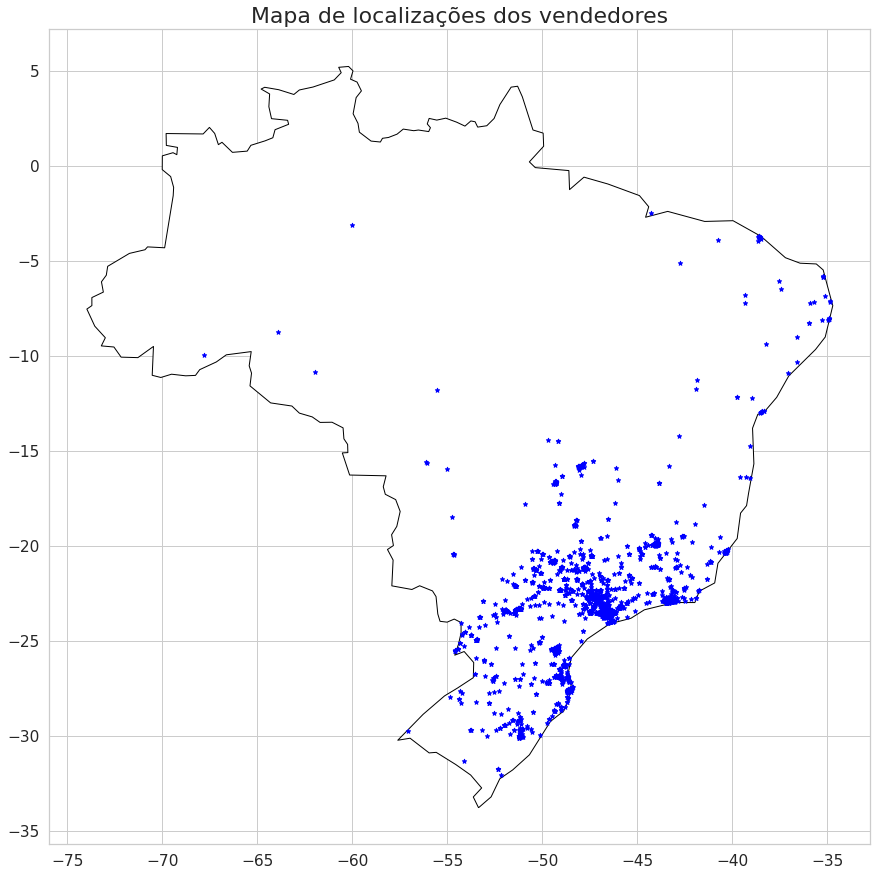

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filtrar Brasil
fig,ax = plt.subplots(figsize = (15,15))
brazil_map_ax = world[world.name == 'Brazil'].plot(color='white', edgecolor='black', ax=ax);
geo_df = gpd.GeoDataFrame(geometry = sellers_geometry)
g = geo_df.plot(ax = brazil_map_ax, markersize = 20, color = 'blue',marker = '*',label = 'Brazil')
g.set_title('Mapa de localizações dos vendedores', fontsize=22)
plt.show()

### **Dataset de Avaliações**
* Cada compra do e-commerce está associada a uma avaliação do usuário
* Podemos relacionar os dois datasets a partir da chave order_id
* Nota-se que o número de order_ids únicos é o mesmo do dataset de compras, o que sugere que ao criar o dataset o provedor tenha filtrado somente clientes que avaliaram sua compra
* Por outro lado, há algumas centenas de casos em que um mesmo review_id é atribuído a diferentes order_id's

In [ ]:
resumetable(df_reviews)
print(df_reviews.head(2).T.to_latex(index=True))

Dataset Shape: (100000, 7)
\begin{tabular}{lll}
\toprule
{} &                                 0 &                                 1 \\
\midrule
review\_id               &  7bc2406110b926393aa56f80a40eba40 &  80e641a11e56f04c1ad469d5645fdfde \\
order\_id                &  73fc7af87114b39712e6da79b0a377eb &  a548910a1c6147796b98fdf73dbeba33 \\
review\_score            &                                 4 &                                 5 \\
review\_comment\_title    &                               NaN &                               NaN \\
review\_comment\_message  &                               NaN &                               NaN \\
review\_creation\_date    &               2018-01-18 00:00:00 &               2018-03-10 00:00:00 \\
review\_answer\_timestamp &               2018-01-18 21:46:59 &               2018-03-11 03:05:13 \\
\bottomrule
\end{tabular}



* Apesar de todos os registros possuirem uma nota de avaliação, nem todas tem um comentário.
* Dado que a análise que pretendemos realizar utiliza como principal métrica de stisfação do cliente sua nota de avaliação, não será necessário utilizar esses dado, portanto podemos desconsiderá-los

* Vamos analisar a distribuição de avaliações por compra

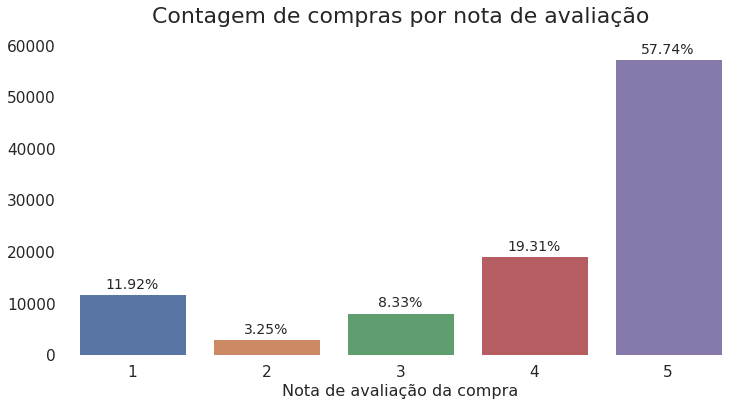

In [ ]:
plot_count_plot(df_reviews,'review_score',
                df_order_pay.order_id.nunique(), 
                'Contagem de compras por nota de avaliação',
                'Nota de avaliação da compra')

* Excluo colunas que não serão utilizadas

In [ ]:
df_reviews = df_reviews[['order_id','review_score']]

### **Dataset de pagamentos**
* Nota-se que há mais linhas no dataset do que order_id's únicos, o que sugere que há mais de um tipo de pagamento por compra
* Para evitar que ocorra uma multiplicação de linhas de compras e itens para cada tipo de pagamento, podemos realizar um pivoteamento dos dados, onde cada um dos 5 tipos de pagamento possíveis se tornariam colunas com um valor de pagamento
* Os campos payment_sequential e payment_installments parecem estar relacionados ao parcelamento do pagamento

In [ ]:
resumetable(df_order_pay)
print(df_order_pay.head(2).T.to_latex(index=True))

Dataset Shape: (103886, 5)
\begin{tabular}{lll}
\toprule
{} &                                 0 &                                 1 \\
\midrule
order\_id             &  b81ef226f3fe1789b1e8b2acac839d17 &  a9810da82917af2d9aefd1278f1dcfa0 \\
payment\_sequential   &                                 1 &                                 1 \\
payment\_type         &                       credit\_card &                       credit\_card \\
payment\_installments &                                 8 &                                 1 \\
payment\_value        &                             99.33 &                             24.39 \\
\bottomrule
\end{tabular}



* Vamos investigar melhor se há algum tipo de pagamento que poderia ser descartado por ser muito pouco relevante
* Aparentemente podemos descartar os pagamentos considerados como "not_defined"

In [ ]:
df_order_pay.groupby(by='payment_type',as_index=False).agg({'order_id':['count','nunique'],
                                                            'payment_value' : 'sum'})
print(df_order_pay.head(2).to_latex(index=False))

\begin{tabular}{lrlrr}
\toprule
                         order\_id &  payment\_sequential & payment\_type &  payment\_installments &  payment\_value \\
\midrule
 b81ef226f3fe1789b1e8b2acac839d17 &                   1 &  credit\_card &                     8 &          99.33 \\
 a9810da82917af2d9aefd1278f1dcfa0 &                   1 &  credit\_card &                     1 &          24.39 \\
\bottomrule
\end{tabular}



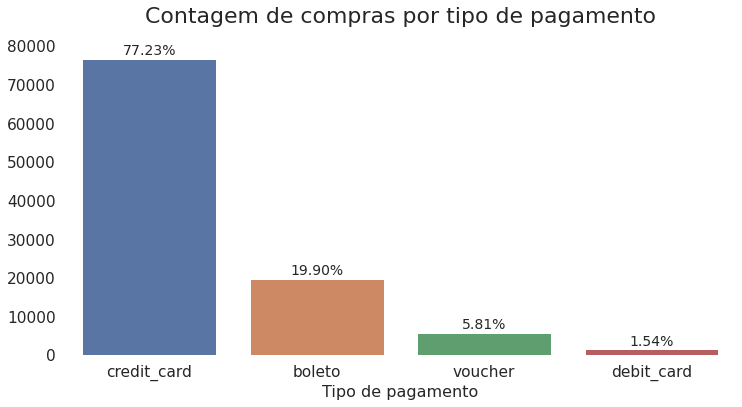

In [ ]:
df_order_pay.drop(df_order_pay[df_order_pay['payment_type'] == 'not_defined'].index, inplace=True)

plot_count_plot(df_order_pay,'payment_type',
                df_order_pay.order_id.nunique(), 
                'Contagem de compras por tipo de pagamento',
                'Tipo de pagamento')

* Repare como as porcentagens com relação ao total somam mais que 100%, indicando que há sobreposição de pagamento de compras por mais de um meio de pagamento

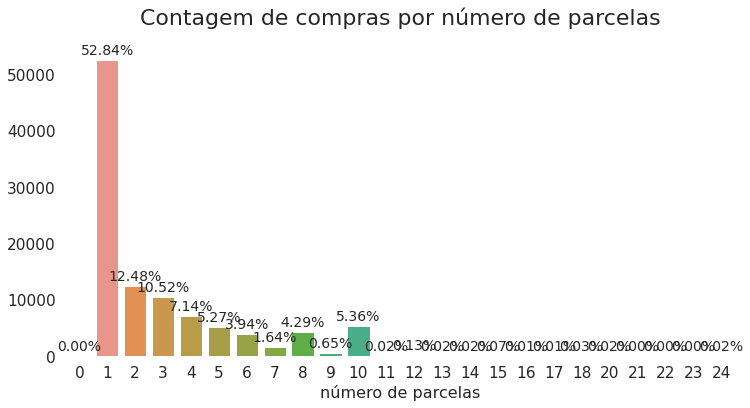

In [ ]:
plot_count_plot(df_order_pay,'payment_installments',
                df_order_pay.order_id.nunique(), 
                'Contagem de compras por número de parcelas',
                'número de parcelas')

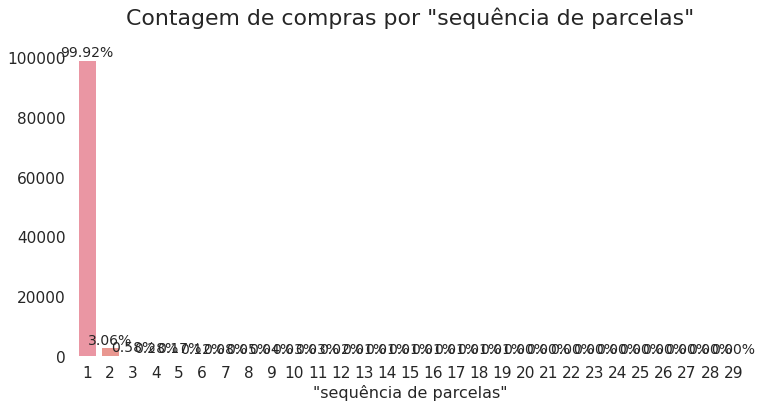

In [ ]:
plot_count_plot(df_order_pay,'payment_sequential',
                df_order_pay.order_id.nunique(), 
                'Contagem de compras por "sequência de parcelas"',
                '"sequência de parcelas"')

* O campo payment_sequential parece ser irrelevante para a análise, porém o campo de número de parcelas parece interessante e será mantido
* O campo de valor do pagamento será pivotado em 4 colunas para cada tipo de pagamento
* O campo de número de parcelas representará uma média do número de parcelas dos meios de pagamento da compra, por simplicidade

In [ ]:
df_order_pay.drop(columns='payment_sequential', inplace=True)
df_order_pay = df_order_pay.groupby(by=['order_id','payment_type'], as_index= False).agg('mean')
resumetable(df_order_pay)
print(df_order_pay.head(2).T.to_latex(index=True))

Dataset Shape: (101683, 4)
\begin{tabular}{lll}
\toprule
{} &                                 0 &                                 1 \\
\midrule
order\_id             &  00010242fe8c5a6d1ba2dd792cb16214 &  00018f77f2f0320c557190d7a144bdd3 \\
payment\_type         &                       credit\_card &                       credit\_card \\
payment\_installments &                                 2 &                                 3 \\
payment\_value        &                             72.19 &                            259.83 \\
\bottomrule
\end{tabular}



In [ ]:
df_order_pay = (df_order_pay.pivot(index=['order_id','payment_installments'],
                  columns='payment_type',values='payment_value').add_prefix('payment_type_')
                .reset_index()
                .fillna(0.0))
df_order_pay.columns.name = 'index'
resumetable(df_order_pay)
print(df_order_pay.head(2).T.to_latex(index=True))

Dataset Shape: (100155, 6)
\begin{tabular}{lll}
\toprule
{} &                                 0 &                                 1 \\
index                    &                                   &                                   \\
\midrule
order\_id                 &  00010242fe8c5a6d1ba2dd792cb16214 &  00018f77f2f0320c557190d7a144bdd3 \\
payment\_installments     &                                 2 &                                 3 \\
payment\_type\_boleto      &                                 0 &                                 0 \\
payment\_type\_credit\_card &                             72.19 &                            259.83 \\
payment\_type\_debit\_card  &                                 0 &                                 0 \\
payment\_type\_voucher     &                                 0 &                                 0 \\
\bottomrule
\end{tabular}



## **Integração dos Datasets**

### **Premissas: Compras - Itens - Produtos**
* Cada compra pode ter diversos itens, que representam um produto. Os atributos de prazo de entrega de compras são portanto herdados para todos os itens dessa compra

* Estamos adotando a premissa de que dois produtos dentro da mesma compra não são entregues em momentos distintos

* Cada item pode ter um vendedor distinto, portanto as distâncias entre o vendedor do produto e o cliente serão distintas

In [ ]:
df_train = df_orders.merge(df_items, on='order_id', how='left')
df_train = df_train.merge(df_products,on='product_id',how='left')
df_train = df_train.merge(df_sellers,on='seller_id',how='left')

### **Premissas: Avaliações e Clientes**
* A conexão de compras, clientes e avaliações são diretas. A cada compra um customer_unique_id é atribuído um customer_id distinto, portanto os atributos da base df_customers são referentes a uma compra e podem ser integrados sem maiores problemas.

* O mesmo ocorre para o dataset de avaliações. Nesse caso, todos os itens da compra herdam a avaliação geral da compra

In [ ]:
df_train = df_train.merge(df_reviews,on='order_id',how='left')
df_train = df_train.merge(df_customers,on='customer_id',how='left')

### **Premissas: Pagamento da compra**

* Ao integrar o dataset de pagamento de compras já tratado é importante tomar um cuidado especial com os valores de pagamaneto das compras

* Como o valor total de pagamento é dado na granularidade de um order_id e o dataset consolidado está na granularidade de item, é necessário realizar um rateio do valor total da compra entre os diversos produtos e podemos fazer isso a prtir do preço do produto.  

In [ ]:
df_train = df_train.merge(df_order_pay, on='order_id',how='left')

###**Enriquecimento de dados**
* Um próximo prazo interessante se torna calcular a distância média entre um cliente e um vendedor durante uma compra.
* Podemos correlacionar essa variável com o prazod e entrega da mercadoria
* Para o caso de integração do dataset de formas de pagamento, seria necessário realizar um rateio do pagamento total da compra por item utilizando para isso o preço do produto

In [ ]:
df_train['freight_distance'] = np.sqrt(np.power(df_train['customer_lat'] - df_train['seller_lat'],2)
                                      +np.power(df_train['customer_lng'] - df_train['seller_lng'],2))

### **Visão geral do dataset**

In [ ]:
resumetable(df_train)

Dataset Shape: (111647, 38)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,order_id,object,0,96455,e481f51cbdc54678b7cc49136f2d6af7,53cdb2fc8bc7dce0b6741e2150273451,47770eb9100c2d0c44946d9cf07ec65d,16.45
1,customer_id,object,0,96455,9ef432eb6251297304e76186b10a928d,b0830fb4747a6c6d20dea0b8c802d7ef,41ce2a54c0b03bf3443c3d931a367089,16.45
2,delivery_days,int64,0,144,8,14,9,4.80
3,late_delivery_days,int64,0,198,-8,-6,-18,5.16
4,estimated_delivery_days,int64,0,100,16,20,27,5.10
5,is_late,bool,0,2,False,False,False,0.35
6,order_item_id,int64,0,21,1,1,1,0.73
7,product_id,object,0,32210,87285b34884572647811a353c7ac498a,595fac2a385ac33a80bd5114aec74eb8,aa4383b373c6aca5d8797843e5594415,13.60
8,seller_id,object,0,2970,3504c0cb71d7fa48d967e0e4c94d59d9,289cdb325fb7e7f891c38608bf9e0962,4869f7a5dfa277a7dca6462dcf3b52b2,9.45
9,shipping_limit_date,object,0,91321,2017-10-06 11:07:15,2018-07-30 03:24:27,2018-08-13 08:55:23,16.34


* Como o número de valores vazios máximo corresponde a aproximadamente 1% do número de linhas do dataset, podemos remover os valores nulos do dataset

In [ ]:
df_train.dropna(inplace=True, how ='any')
resumetable(df_train)

Dataset Shape: (109535, 38)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,order_id,object,0,94652,e481f51cbdc54678b7cc49136f2d6af7,53cdb2fc8bc7dce0b6741e2150273451,47770eb9100c2d0c44946d9cf07ec65d,16.42
1,customer_id,object,0,94652,9ef432eb6251297304e76186b10a928d,b0830fb4747a6c6d20dea0b8c802d7ef,41ce2a54c0b03bf3443c3d931a367089,16.42
2,delivery_days,int64,0,142,8,14,9,4.80
3,late_delivery_days,int64,0,196,-8,-6,-18,5.16
4,estimated_delivery_days,int64,0,100,16,20,27,5.11
5,is_late,bool,0,2,False,False,False,0.35
6,order_item_id,int64,0,21,1,1,1,0.73
7,product_id,object,0,31521,87285b34884572647811a353c7ac498a,595fac2a385ac33a80bd5114aec74eb8,aa4383b373c6aca5d8797843e5594415,13.57
8,seller_id,object,0,2907,3504c0cb71d7fa48d967e0e4c94d59d9,289cdb325fb7e7f891c38608bf9e0962,4869f7a5dfa277a7dca6462dcf3b52b2,9.42
9,shipping_limit_date,object,0,89702,2017-10-06 11:07:15,2018-07-30 03:24:27,2018-08-13 08:55:23,16.32


In [ ]:
df_sellers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3095 entries, 0 to 3094
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   seller_id     3095 non-null   object 
 1   seller_city   3095 non-null   object 
 2   seller_state  3095 non-null   object 
 3   seller_lat    3088 non-null   float64
 4   seller_lng    3088 non-null   float64
dtypes: float64(2), object(3)
memory usage: 145.1+ KB


In [ ]:
key_columns = ['order_id','order_item_id','customer_id','customer_unique_id','product_id','seller_id'];
categorical_columns = ['shipping_limit_date','product_category_name','seller_city','seller_state','customer_city','customer_state']
aux_columns = ['customer_lat','customer_lng','seller_lat','seller_lng'];
cols_to_drop = ['payment_type_debit_card','payment_type_credit_card','payment_type_boleto','payment_type_voucher','payment_installments',
                'price','late_delivery_days','delivery_days','is_late','freight_value']

* Plotando a matriz de correlação entre diversos atributos e o **review_score**, podemos notar que nenhum deles apresenta uma correlação linear forte com a satisfação do cliente

* Os atributos com maior correlação são os atributos que trazem métricas de prazo de entrega, mas chegam a algo em torno de +/- 20%

* Isso indica que os atributos que temos não seriam bons estimadores do review_score em um modelo de regressão linear e teríamos que utilizar um outro modelo

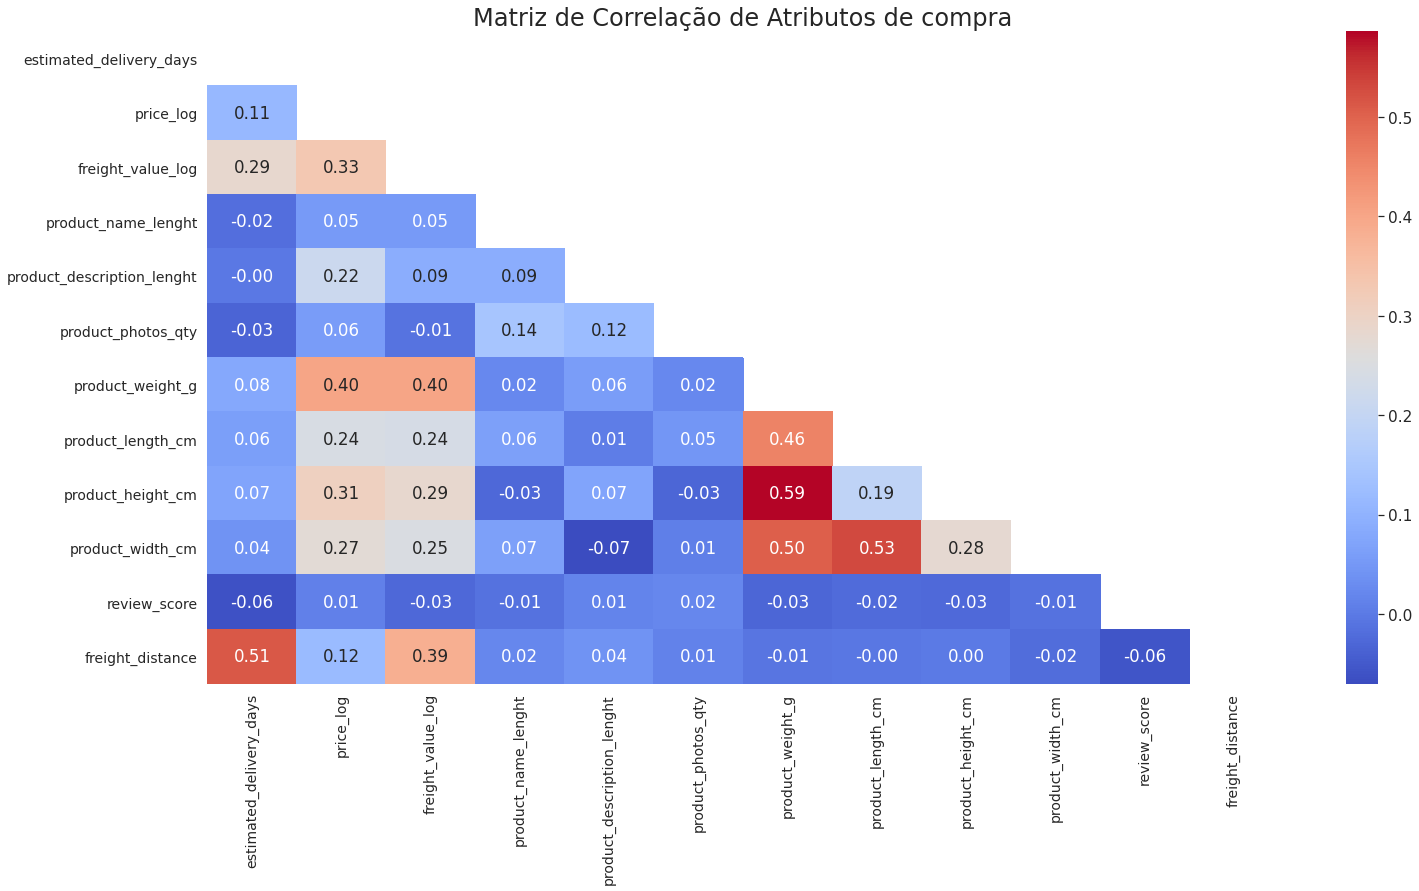

In [ ]:
plt.figure(figsize=(24,12))

corr_matrix = df_train.drop(columns=key_columns + categorical_columns + aux_columns + cols_to_drop).corr()

g = sns.heatmap(corr_matrix,
                cmap = 'coolwarm',
                annot=True,
                fmt='.2f',
                mask = np.triu(corr_matrix))

sns.set_style("whitegrid")
sns.set(font_scale=1.4)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 14);
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 14);
g.set_title('Matriz de Correlação de Atributos de compra', fontsize=24)
plt.show()

**Analisar se será necessário realizarmos um PCA para reduzir multicolinearidade entre preditores**

* Link para estudo: [Discussões sobre Multicolinearidade](https://www.researchgate.net/post/How_to_deal_with_high_correlation_among_predictors_in_multiple_regressions)
* Link para estudo: [Detailed explanation of Linear Regression](https://medium.com/all-about-ml/linear-regression-d41a6a5dcab6)

**Seleção de variáveis disponíveis em "cold start"**

* Seleção de variáveis relacionadas ao produto
* Variável estimated_delivery_days e freigth_value disponíveis quando um cliente decide comprar um produto

In [ ]:
corr_matrix['review_score'].sort_values(ascending=False)

review_score                  1.000000
product_photos_qty            0.022047
product_description_lenght    0.014901
price_log                     0.010433
product_name_lenght          -0.012202
product_width_cm             -0.013070
product_length_cm            -0.022647
product_height_cm            -0.025883
freight_value_log            -0.027592
product_weight_g             -0.029710
freight_distance             -0.057269
estimated_delivery_days      -0.061638
Name: review_score, dtype: float64

In [ ]:
%cd "/content/drive/Shared drives/Projeto Ciência de Dados/dataset/treated_olist_ecommerce/"  
df_train.drop(columns=key_columns + categorical_columns + aux_columns + cols_to_drop).to_csv('olist_consolidated.csv' )

/content/drive/Shared drives/Projeto Ciência de Dados/dataset/treated_olist_ecommerce
